# Задача

Прогнозирование продаж каждого SKU (артикул) с целью формирования оптимального заказа на год вперед на базе параметра "покрытие" (кол-во месяцев до полного истощения стока)

### 1. загружаем необходимые пакеты

In [2]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

### 2. загружаем данные продаж

In [4]:
df = pd.read_csv("bottles.csv", sep = ";", encoding = "latin")

In [5]:
df

,Wine.Denom.True,Year,Month,bottles
0,00100114 / LE DOMAINE BLANCO DE GUARDA / White...,2017,1,1
1,"00100224 / P.V. / Red / 0,75",2017,1,0
2,"00100324 / PAGO GARDUNA / Red / 0,75",2017,1,7
3,"00100424 / PAGO NEGRALADA / Red / 0,75",2017,1,4
4,"00100524 / PAGO VALDEBELLON / Red / 0,75",2017,1,3
...,...,...,...,...
100305,"90400173 / AQUA VITAE / Other / 0,7",2020,9,7
100306,"90500124 / TENUTA DI TRINORO / Red / 0,75",2020,9,0
100307,"90500226 / TENUTA DI TRINORO / Red / 1,5",2020,9,0
100308,"90600124 / Ronan by Clinet / Red / 0,75",2020,9,0


In [6]:
df.rename(columns = {'Unnamed: 0': 'num', 'V1': 'bottles', 'Wine.Denom.True': 'Wine_Denom'}, inplace = True)

In [7]:
df.tail()

,Wine_Denom,Year,Month,bottles
100305,"90400173 / AQUA VITAE / Other / 0,7",2020,9,7
100306,"90500124 / TENUTA DI TRINORO / Red / 0,75",2020,9,0
100307,"90500226 / TENUTA DI TRINORO / Red / 1,5",2020,9,0
100308,"90600124 / Ronan by Clinet / Red / 0,75",2020,9,0
100309,"90600214 / Ronan by Clinet / White / 0,75",2020,9,0


### 3. формируем список со всеми SKU:

In [8]:
wines = df['Wine_Denom'].unique()

In [9]:
import datetime as dt

### 4. преобразовываем колонку с датой

In [10]:
df['date'] = df.apply(lambda x: str(round(x.Year)) + '-' + str(round(x.Month)) + '-' + str(1), axis=1)

In [11]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d', errors='coerce')

In [12]:
df.tail()

,Wine_Denom,Year,Month,bottles,date
100305,"90400173 / AQUA VITAE / Other / 0,7",2020,9,7,2020-09-01
100306,"90500124 / TENUTA DI TRINORO / Red / 0,75",2020,9,0,2020-09-01
100307,"90500226 / TENUTA DI TRINORO / Red / 1,5",2020,9,0,2020-09-01
100308,"90600124 / Ronan by Clinet / Red / 0,75",2020,9,0,2020-09-01
100309,"90600214 / Ronan by Clinet / White / 0,75",2020,9,0,2020-09-01


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100310 entries, 0 to 100309
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Wine_Denom  100310 non-null  object        
 1   Year        100310 non-null  int64         
 2   Month       100310 non-null  int64         
 3   bottles     100310 non-null  int64         
 4   date        100310 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 3.8+ MB


### 5. Строим прогноз продаж на базе метода тройного экспоненциального сглаживания 

In [14]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [15]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [16]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [17]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    i = 0
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = 0.1 #initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

#### Выбираем наиболее подходящие гиперпараметры исходя из максимальной средней оценки R2: 

In [18]:
mean_r2_score = []
num = 0

for alpha in [0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]:
    for beta in [0.05, 0.1, 0.15, 0.2, 0.25, 0.30, 0.35, 0.4, 0.45, 0.5]:
        num += 1
        
        gamma = 0.2
        n_preds = 12
        
        prediction = pd.DataFrame(columns=list(range(0,12)), index=wines)
        performance = pd.DataFrame(columns=list(['r2_score', 'MSE']), index=wines)
        history_forecast = pd.DataFrame(columns=list(range(0,57)), index=wines)
    
        for wine in wines:
            NM_value = str(wine)
            wine_series = df[df.Wine_Denom == wine]
        
            if wine_series[-12:]['date'].iloc[0] >= pd.to_datetime(str(date_string), format='%Y-%m-%d', errors='coerce'):
                try: 
                    forecast = triple_exponential_smoothing(wine_series['bottles'].values, 12, alpha, beta, gamma, n_preds)
                    history_forecast.loc[wine] = forecast
                    forecast_row = pd.Series(forecast[-12:]).values
                    forecast_row[forecast_row < 0] = int(wine_series['bottles'].mean())
                    prediction.loc[wine] = forecast_row
                except:
                    prediction.loc[wine] = int(wine_series['bottles'].mean())
            else:
                prediction.loc[wine] = 0
        
            performance.loc[wine]['r2_score'] = r2_score(wine_series['bottles'], np.array(forecast[:-12]).round())
            performance.loc[wine]['MSE'] = mean_squared_error(wine_series['bottles'], np.array(forecast[:-12]).round())
        
        mean_r2_score.append(performance['r2_score'].mean())                                                  

NameError: name 'date_string' is not defined

In [352]:
mean_r2_score

[-0.046552095977333376,
 0.09326758094308883,
 0.1558752786366366,
 0.18380492286056177,
 0.2021223937089211,
 0.21284259863091287,
 0.42076455356895376,
 0.42159342420968177,
 0.42134202899933365,
 0.4180266962880183,
 0.2929595179301269,
 0.5488201029658912,
 0.5606517922160321,
 0.5625756986218992,
 0.5658538969759763,
 0.5637764617965353,
 0.5583497987382684,
 0.5532673109312835,
 0.5493622030889704,
 0.5428422765090355,
 0.6290703009493969,
 0.6470625534594138,
 0.6482909822180176,
 0.6471218826110128,
 0.6437380110533398,
 0.6389899293977381,
 0.6333528928297869,
 0.6269847054437705,
 0.6205715631834866,
 0.6137317468550217,
 0.6991263535527408,
 0.7038174632691554,
 0.7028336455588731,
 0.700670604778146,
 0.697006955440355,
 0.692832193146972,
 0.6875485645608744,
 0.6840460435061375,
 0.6798890927677104,
 0.6769207408923508,
 0.7424691576462684,
 0.7452379847611854,
 0.7442586820470195,
 0.7422192696705827,
 0.7405142280865967,
 0.7370923854472103,
 0.7340382217486439,
 0.7325

### 6. Строим саму таблицу с прогнозами для каждого SKU:

In [18]:
prediction = pd.DataFrame(columns=list(range(0,12)), index=wines)
performance = pd.DataFrame(columns=list(['r2_score', 'MSE']), index=wines)
history_forecast = pd.DataFrame(columns=list(range(0,57)), index=wines)

In [19]:
alpha = 0.5
beta = 0.1
gamma = 0.2
n_preds = 12

In [20]:
date_string = '2018-09-01'

In [21]:
for wine in wines:
    NM_value = str(wine)
    wine_series = df[df.Wine_Denom == wine]
    
    if wine_series[-12:]['date'].iloc[0] >= pd.to_datetime(str(date_string), format='%Y-%m-%d', errors='coerce'):
        try: 
            forecast = triple_exponential_smoothing(wine_series['bottles'].values, 12, alpha, beta, gamma, n_preds)
            forecast_row = pd.Series(forecast[-12:]).values
            forecast_row[forecast_row < 0] = abs(forecast_row[forecast_row < 0]/2)
            #forecast_row[forecast_row < 0] = int(wine_series['bottles'].mean())
            
            prediction.loc[wine] = forecast_row
            
            combined_forecast = list(forecast[:-12]) + list(forecast_row)
            combined_forecast = np.array(combined_forecast)
            history_forecast.loc[wine] = combined_forecast
        except:
            prediction.loc[wine] = int(wine_series['bottles'].mean())
    else:
        prediction.loc[wine] = 0
    
    #accuracy = r2_score(wine_series['bottles'], np.array(forecast[:-12]).round())
    #prediction = prediction.append(accuracy)
    performance.loc[wine]['r2_score'] = r2_score(wine_series['bottles'], np.array(forecast[:-12]).round())
    performance.loc[wine]['MSE'] = mean_squared_error(wine_series['bottles'], np.array(forecast[:-12]).round())
    
    #accuracy_scores.append(r2_score(wine_series['bottles'], np.array(forecast[:-12]).round()))
    #mse_table.append(mean_squared_error(wine_series['bottles'], np.array(forecast[:-12]).round()))

In [22]:
print(performance['r2_score'].mean())

0.8945789839697366


In [23]:
test_wine = '15101514 / RIESLING BONEDRY / White / 0,75'

In [24]:
performance.loc[test_wine]

r2_score    0.900967
MSE          14485.2
Name: 15101514 / RIESLING BONEDRY / White / 0,75, dtype: object

In [25]:
prediction.loc[test_wine]

0     1120.85
1     1006.31
2      1409.3
3     1334.55
4     1300.47
5     1379.12
6     1476.39
7     1539.36
8     1713.03
9     1742.09
10     1846.6
11    1771.44
Name: 15101514 / RIESLING BONEDRY / White / 0,75, dtype: object

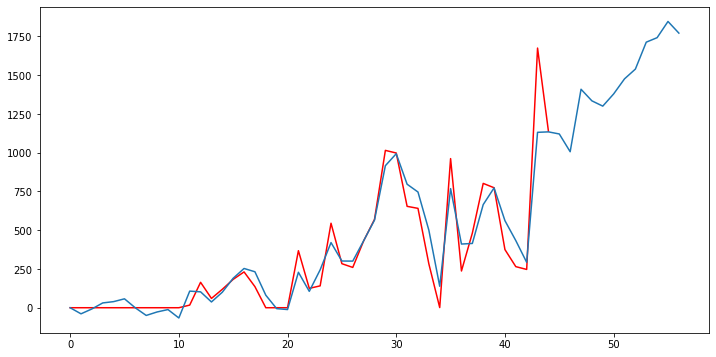

In [26]:
plt.figure(figsize=(12, 6))
plt.plot(df[df.Wine_Denom == test_wine]['bottles'].values, "r")
plt.plot(history_forecast.loc[test_wine][:])

In [27]:
prediction.head()

,0,1,2,3,4,5,6,7,8,9,10,11
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",0.481278,1.60818,12.4071,0.161785,5.19903,13.4002,10.859,11.4677,17.1831,0.470847,3.48422,2.43917
"00100224 / P.V. / Red / 0,75",1.5409,0.597151,6.80771,0.920272,3.5714,6.15826,5.68553,2.01117,1.40609,1.42554,2.89665,1.78408
"00100324 / PAGO GARDUNA / Red / 0,75",6.09771,1.46943,0.770256,2.08744,2.73989,4.26619,1.38503,2.24071,1.53384,1.73189,0.00789266,0.570802
"00100424 / PAGO NEGRALADA / Red / 0,75",7.30287,11.4351,9.95824,8.70417,7.25206,11.0605,11.9239,8.36242,10.7619,11.2648,11.3276,10.9977
"00100524 / PAGO VALDEBELLON / Red / 0,75",0.00836503,0.222848,0.23218,0.20692,4.09637,0.95231,0.111441,1.87871,0.446217,0.000894696,7.05235,2.89289


In [28]:
prediction.to_csv('prediction.csv', encoding='utf-8', sep = ';')

### 7. Добавляем информацию о стоках

In [28]:
inventory = pd.read_csv("inventory.csv", encoding = 'latin', sep = ';')

In [29]:
inventory.head()

,Denom,Girteka,Moscow,Pade,Unpade,Truck,avg_sales,avg_prices,avg_cost
0,00100114 / LE DOMAINE BLANCO DE GUARDA / White...,0,38,0,0,0,10.0,1924.021531,683.558662
1,"00100224 / P.V. / Red / 0,75",0,98,0,0,0,3.0,8578.949045,3379.575468
2,"00100324 / PAGO GARDUNA / Red / 0,75",0,187,0,0,0,4.0,6359.677305,2225.761275
3,"00100424 / PAGO NEGRALADA / Red / 0,75",0,199,0,0,0,4.0,6331.125581,2391.717028
4,"00100524 / PAGO VALDEBELLON / Red / 0,75",0,179,0,0,0,4.0,6180.007143,2340.314341


In [32]:
inventory = inventory.set_index('Denom')

In [34]:
inventory.head()

,Girteka,Moscow,Pade,Unpade,Truck,avg_sales,avg_prices,avg_cost
Denom,,,,,,,,
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",0,38,0,0,0,10.0,1924.021531,683.558662
"00100224 / P.V. / Red / 0,75",0,98,0,0,0,3.0,8578.949045,3379.575468
"00100324 / PAGO GARDUNA / Red / 0,75",0,187,0,0,0,4.0,6359.677305,2225.761275
"00100424 / PAGO NEGRALADA / Red / 0,75",0,199,0,0,0,4.0,6331.125581,2391.717028
"00100524 / PAGO VALDEBELLON / Red / 0,75",0,179,0,0,0,4.0,6180.007143,2340.314341


### 8. Строим алгоритм расчета заказа исходя из прогноза продаж

In [35]:
import random

#### подготовительные таблицы:

In [36]:
#create and calculate future stock data

#stock
stock = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
girteka = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
truck = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
pade = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
unpade = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

stock.fillna(random.random(), inplace = True)
girteka.fillna(random.random(), inplace = True)
truck.fillna(random.random(), inplace = True)
pade.fillna(random.random(), inplace = True)
unpade.fillna(random.random(), inplace = True)

#covers
p_one = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
p_two = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
p_three = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
p_four = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

p_one.fillna(random.random(), inplace = True)
p_two.fillna(random.random(), inplace = True)
p_three.fillna(random.random(), inplace = True)
p_four.fillna(random.random(), inplace = True)

#signals
signal_move = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
signal_order = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

signal_move.fillna(0, inplace = True)
signal_order.fillna(0, inplace = True)

#actions
move = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
purchase = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)

move.fillna(0, inplace = True)
purchase.fillna(0, inplace = True)


#cover = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#signal = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
prices = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
revenue = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
expenses = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#price_increase_pct = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#discounts = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
cost_prices_eur = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#cost_increase_pct = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)
#profit = instead get expenses with minus sign
#margin = pd.DataFrame(columns=prediction.iloc[:,:-1].columns, index=prediction.index)


#stock.fillna(0, inplace = True)
#purchase.fillna(0, inplace = True)
#cover.fillna(0, inplace = True)
#signal.fillna(0, inplace = True)
prices.fillna(0, inplace = True)
revenue.fillna(0, inplace = True)
expenses.fillna(0, inplace = True)
#price_increase_pct.fillna(0, inplace = True)
#discounts.fillna(0, inplace = True)
cost_prices_eur.fillna(0, inplace = True)
#cost_increase_pct.fillna(0, inplace = True)
#margin.fillna(0, inplace = True)

#### реализуем сам алгоритм через for loop:

In [37]:
# testing with producer 
num = 0
for i in prediction.index:
    num += 1
    for j in list(prediction.iloc[:,:-1].columns):

        optimal_coverage = 3
        optimal_p_four = optimal_coverage + 1
        optimal_p_three = optimal_coverage + 3
        
        try:
        
            if j == 0:

                signal_move.loc[i][j] = 1 if ((inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck']) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_four])) < optimal_p_four else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                current_stock = (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] + inventory.loc[i]['Girteka'] + inventory.loc[i]['Unpade'] + inventory.loc[i]['Pade'])
                    
                signal_order.loc[i][j] = 1 if ((current_stock / np.mean(prediction.loc[i][j+1:j+1+optimal_coverage])) < optimal_p_three) and (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0) else 0
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j]
                pade.loc[i][j] = inventory.loc[i]['Unpade']
                
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] < 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - inventory.loc[i]['Truck'] > 0 and inventory.loc[i]['Girteka'] > move.loc[i][j] - inventory.loc[i]['Truck']:
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = inventory.loc[i]['Girteka']
            
                girteka.loc[i][j] = inventory.loc[i]['Girteka'] + inventory.loc[i]['Pade'] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j]) < 0 else (inventory.loc[i]['Moscow'] + inventory.loc[i]['Truck'] - prediction.loc[i][j])
                prediction.loc[i][j] = inventory.loc[i]['Moscow'] if prediction.loc[i][j] > inventory.loc[i]['Moscow'] else prediction.loc[i][j]
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost'] / 90
        
            else:
                
                signal_move.loc[i][j] = 1 if (p_four.loc[i][j-1] < optimal_p_four) else 0
                move.loc[i][j] = sum(prediction.loc[i][j+1:j+1+optimal_p_four]) if signal_move.loc[i][j] > 0 else 0
                
                #signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                try:
                    if (signal_order.loc[i][j-1] == 1) or (signal_order.loc[i][j-2] == 1) or (signal_order.loc[i][j-3] == 1):
                        signal_order.loc[i][j] = 0
                    else:
                        signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                except:
                    signal_order.loc[i][j] = 1 if p_three.loc[i][j-1] < optimal_p_three else 0
                
                purchase.loc[i][j] = 24 * round(sum(prediction.loc[i][j:j+optimal_p_three])/24) if signal_order.loc[i][j] > 0 else 0
                
                unpade.loc[i][j] = purchase.loc[i][j].tolist()
                pade.loc[i][j] = unpade.loc[i][j-1]
            
                if signal_move.loc[i][j] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] == 0:
                    truck.loc[i][j] = 0
                elif move.loc[i][j] - truck.loc[i][j-1] < 0:
                    truck.loc[i][j] = 0
                elif (move.loc[i][j] - truck.loc[i][j-1] > 0) and girteka.loc[i][j] > (move.loc[i][j] - truck.loc[i][j-1]):
                    truck.loc[i][j] = move.loc[i][j]
                else:
                    truck.loc[i][j] = girteka.loc[i][j-1]
            
            
                girteka.loc[i][j] = girteka.loc[i][j-1] + pade.loc[i][j-1] - truck.loc[i][j]
                stock.loc[i][j] = 0 if (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j]) < 0 else (stock.loc[i][j-1] + truck.loc[i][j-1] - prediction.loc[i][j])
                prediction.loc[i][j] = stock.loc[i][j-1] if prediction.loc[i][j] > stock.loc[i][j-1] else prediction.loc[i][j]  
            
                p_one.loc[i][j] = (stock.loc[i][j]) / (np.mean(prediction.loc[i][j+1:j+1+optimal_p_three])) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_two.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_three.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j] + girteka.loc[i][j] + pade.loc[i][j] + unpade.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else 0 #look in future
                p_four.loc[i][j] = (stock.loc[i][j] + truck.loc[i][j]) / np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) if np.mean(prediction.loc[i][j+1:j+1+optimal_p_three]) > 0 else (optimal_p_four + 1) #look in future 
            
                prices.loc[i][j] = inventory.loc[i]['avg_prices']
                cost_prices_eur.loc[i][j] = inventory.loc[i]['avg_cost'] / 90
        except:
            next

#### Проверяем интуитивно правильность работы на базе тестового вина

In [38]:
test_wine = '11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75'

In [39]:
inventory.loc[test_wine]

Girteka          0.000000
Moscow         633.000000
Pade             0.000000
Unpade        3000.000000
Truck            0.000000
avg_sales      283.000000
avg_prices    1103.518259
avg_cost       672.099679
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [40]:
signal_order.loc[test_wine]

0     1
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    1
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: int64

In [41]:
stock.loc[test_wine]

0       92.778011
1        0.000000
2        0.000000
3     2690.307051
4     2259.573674
5     1789.251726
6     1340.033222
7     4253.303789
8     3802.612482
9     3390.990987
10    2846.788162
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [42]:
signal_move.loc[test_wine]

0     1
1     1
2     1
3     0
4     0
5     0
6     1
7     0
8     0
9     0
10    0
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: int64

In [43]:
girteka.loc[test_wine]

0        0.0
1     3000.0
2     3360.0
3     3360.0
4     3360.0
5     3360.0
6        0.0
7        0.0
8        0.0
9        0.0
10       0.0
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [44]:
truck.loc[test_wine]

0        0.0
1        0.0
2     3000.0
3        0.0
4        0.0
5        0.0
6     3360.0
7        0.0
8        0.0
9        0.0
10       0.0
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [45]:
purchase.loc[test_wine]

0     3360
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10    1152
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: int64

In [46]:
p_one.loc[test_wine]

0     0.169716
1     0.000000
2     0.000000
3     6.069922
4     4.889467
5     3.698747
6     2.731134
7     8.478947
8     7.332301
9     5.927209
10    4.744576
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [47]:
p_two.loc[test_wine]

0      5.657521
1     12.493263
2     14.921477
3     13.650819
4     12.160134
5     10.644549
6      9.579182
7      8.478947
8      7.332301
9      5.927209
10     4.744576
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [48]:
p_three.loc[test_wine]

0     11.803863
1     12.493263
2     14.921477
3     13.650819
4     12.160134
5     10.644549
6      9.579182
7      8.478947
8      7.332301
9      5.927209
10     6.664548
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [49]:
p_four.loc[test_wine]

0     0.169716
1     0.000000
2     7.038433
3     6.069922
4     4.889467
5     3.698747
6     9.579182
7     8.478947
8     7.332301
9     5.927209
10    4.744576
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [50]:
unpade.loc[test_wine]

0     3360.0
1        0.0
2        0.0
3        0.0
4        0.0
5        0.0
6        0.0
7        0.0
8        0.0
9        0.0
10    1152.0
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: float64

In [51]:
prediction.loc[test_wine]

0     540.222
1      92.778
2           0
3           0
4     430.733
5     470.322
6     449.219
7     446.729
8     450.691
9     411.621
10    544.203
11    600.009
Name: 11500924 / PHILIPP KUHN SPATBURGUNDER TRADITION / Red / 0,75, dtype: object

### 8. Добавляем также информацию о курсе евро для расчета выручки и расходов

In [54]:
#currency
forward_12m_eurrub = [88.8017, 89.1386, 89.4760, 89.8561, 90.2041, 90.5312, 
                      90.8500, 91.3000, 91.6025, 91.9000, 92.3000, 92.7642]

spot_rate = forward_12m_eurrub

hedging_eurrub = [79.14, 86.26, 0, 80.60, 0, 0,
                  82.05, 0, 0, 83.56, 0, 0]
                  
hedging_cost = [0.05, 0.05, 0, 0.05, 0, 0,
                0.05, 0, 0, 0.05, 0, 0]
                
hedging_sum = [252726, 579630, 0, 248133, 0, 0,
               243763, 0, 0, 239343, 0, 0]

In [55]:
hedging_result = ((list((np.array(forward_12m_eurrub) - np.array(hedging_eurrub)) * np.array(hedging_sum) / np.array(forward_12m_eurrub))))
hedging_cost_eur = list(-np.array(hedging_cost) * np.array(hedging_sum))
hedging_profit = list(np.array(hedging_result) + np.array(hedging_cost_eur))

In [56]:
hedging = pd.DataFrame(hedging_profit)
hedging = hedging.rename(columns = {0: 'hedging'})
hedging = np.transpose(hedging)
hedging

,0,1,2,3,4,5,6,7,8,9,10,11
hedging,14860.502361,-10263.201552,0.0,13153.594227,0.0,0.0,11423.455944,0.0,0.0,9753.422579,0.0,0.0


In [57]:
receivables = [0.66, 0.33]

for i in prediction.index:
    for j in list(prediction.iloc[:,:-1].columns):
        if j == 0:
            revenue.loc[i][0] = (prices.loc[i][j] * prediction.loc[i][j] * receivables[0]) / forward_12m_eurrub[0]
        else:
            revenue.loc[i][j] = (prices.loc[i][j] * prediction.loc[i][j] * receivables[0] + prices.loc[i][j] * prediction.loc[i][j-1] * receivables[1]) / forward_12m_eurrub[11] 

In [58]:
for i in prediction.index:
    for j in list(prediction.iloc[:,:-1].columns):
        expenses.loc[i][j] = (purchase.loc[i][j] * cost_prices_eur.loc[i][j])

### 9. Смотрим результаты:

In [125]:
prediction.head()

,0,1,2,3,4,5,6,7,8,9,10,11
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",8.68973,0.035876,0,0,0,0,13.8123,13.829,18.7162,6.758,10.1195,4.46125
"00100224 / P.V. / Red / 0,75",0.001,0.001,0.304018,0,0,1.31701,0,0,0,0,0,10.0412
"00100324 / PAGO GARDUNA / Red / 0,75",6.70633,0.035876,0,0,0,0,0,4.40391,3.57526,4.93226,3.58685,3.12433
"00100424 / PAGO NEGRALADA / Red / 0,75",0.001,0.035876,0,0,0,0.428362,0.609949,0,0,0.121967,0.001,27.854
"00100524 / PAGO VALDEBELLON / Red / 0,75",0.001,0.001,0.001,0.001,0.829548,0.001,0.001,0.001,0.001,0.001,0.883471,27.061


In [126]:
stock.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",29.310272,29.274396,29.274396,29.274396,29.274396,29.274396,63.462060,49.633070,30.916856,24.158860,14.039384
"00100224 / P.V. / Red / 0,75",97.999000,97.998000,97.693982,97.693982,97.693982,96.376975,96.376975,96.376975,96.376975,96.376975,96.376975
"00100324 / PAGO GARDUNA / Red / 0,75",180.293669,180.257793,180.257793,180.257793,180.257793,180.257793,180.257793,175.853883,172.278623,167.346367,163.759520
"00100424 / PAGO NEGRALADA / Red / 0,75",198.999000,198.963124,198.963124,198.963124,198.963124,198.534762,197.924813,197.924813,197.924813,197.802847,197.801847
"00100524 / PAGO VALDEBELLON / Red / 0,75",178.999000,178.998000,178.997000,178.996000,178.166452,178.165452,178.164452,178.163452,178.162452,178.161452,177.277980


In [127]:
girteka.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",0.0,0.0,48.0,48.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100224 / P.V. / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100324 / PAGO GARDUNA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100424 / PAGO NEGRALADA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100524 / PAGO VALDEBELLON / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [128]:
truck.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",0.0,0.0,0.0,0.0,0.0,48.0,0.0,0.0,0.0,0.0,0.0
"00100224 / P.V. / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100324 / PAGO GARDUNA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100424 / PAGO NEGRALADA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100524 / PAGO VALDEBELLON / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [129]:
pade.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",0.0,48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100224 / P.V. / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100324 / PAGO GARDUNA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100424 / PAGO NEGRALADA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100524 / PAGO VALDEBELLON / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
unpade.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",48.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100224 / P.V. / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100324 / PAGO GARDUNA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100424 / PAGO NEGRALADA / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"00100524 / PAGO VALDEBELLON / Red / 0,75",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [131]:
signal_move.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",0,0,0,0,0,1,0,0,0,0,1
"00100224 / P.V. / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100324 / PAGO GARDUNA / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100424 / PAGO NEGRALADA / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100524 / PAGO VALDEBELLON / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0


In [132]:
signal_order.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",1,0,0,0,0,0,0,0,0,0,0
"00100224 / P.V. / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100324 / PAGO GARDUNA / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100424 / PAGO NEGRALADA / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100524 / PAGO VALDEBELLON / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0


In [133]:
purchase.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",48,0,0,0,0,0,0,0,0,0,0
"00100224 / P.V. / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100324 / PAGO GARDUNA / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100424 / PAGO NEGRALADA / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0
"00100524 / PAGO VALDEBELLON / Red / 0,75",0,0,0,0,0,0,0,0,0,0,0


In [134]:
p_one.head()

,0,1,2,3,4,5,6,7,8,9,10
"00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75",2450.966346,4.000000,4.000000,6.358316,3.177242,1.894475,4.844038,4.183304,4.346586,3.313808,3.146964
"00100224 / P.V. / Red / 0,75",963.868008,967.028572,222.536323,222.536323,222.536323,4.000000,4.000000,4.000000,28.794552,19.196368,9.598184
"00100324 / PAGO GARDUNA / Red / 0,75",15076.411251,4.000000,4.000000,4.000000,122.793903,67.773137,41.883317,43.620458,44.388632,49.870982,52.414364
"00100424 / PAGO NEGRALADA / Red / 0,75",16640.577407,4.000000,1393.423989,574.865934,574.865934,976.482219,4868.332332,4828.741677,21.223659,14.202302,7.101370
"00100524 / PAGO VALDEBELLON / Red / 0,75",178999.000000,645.776015,645.772407,645.768799,178166.451619,178165.451619,178164.451619,603.622573,19.126064,12.751094,6.551044


In [65]:
p_two.head()

,0,1,2,3,4,5,6,7,8,9,10
MIA IDA BRUT,4.534269,10.380914,7.230806,6.830553,5.513827,5.905711,4.424048,2.983285,2.405307,5.0,5.0
L'AMIRAL SANCERRE,0.818574,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.0
"DOMAINE DE LA GRENAUDIERE ""La Grenouille"" MUSCADET SEVRE ET MAINE SUR LIE",22.589296,22.575906,16.855733,13.857812,10.378954,9.502116,8.370479,7.356981,5.277653,5.0,5.0
"PULIGNY-MONTRACHET 1er Cru ""Les Folatieres""",9.409038,9.281640,9.220163,7.561433,7.201626,5.530050,4.161624,5.584906,5.208309,5.0,5.0
LE RENARD BOURGOGNE CHARDONNAY,8.821421,8.268199,7.731929,6.239412,5.577352,4.394943,7.091602,6.104333,4.964967,5.0,5.0


In [66]:
p_three.head()

,0,1,2,3,4,5,6,7,8,9,10
MIA IDA BRUT,10.765707,10.380914,7.230806,6.830553,5.513827,5.905711,4.424048,2.983285,2.405307,7.0,7.0
L'AMIRAL SANCERRE,0.337809,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.0,7.0
"DOMAINE DE LA GRENAUDIERE ""La Grenouille"" MUSCADET SEVRE ET MAINE SUR LIE",22.589296,22.575906,16.855733,13.857812,10.378954,9.502116,8.370479,7.356981,5.277653,7.0,7.0
"PULIGNY-MONTRACHET 1er Cru ""Les Folatieres""",9.409038,9.281640,9.220163,7.561433,7.201626,5.530050,7.215986,5.584906,6.071642,7.0,7.0
LE RENARD BOURGOGNE CHARDONNAY,8.821421,8.268199,7.731929,6.239412,5.577352,8.657231,7.091602,6.104333,4.964967,7.0,7.0


In [67]:
p_four.head()

,0,1,2,3,4,5,6,7,8,9,10
MIA IDA BRUT,3.673582,2.923559,2.007674,7.835229,5.397097,5.066809,3.907901,3.078888,2.169197,1.105999,0.078767
L'AMIRAL SANCERRE,0.950782,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
"DOMAINE DE LA GRENAUDIERE ""La Grenouille"" MUSCADET SEVRE ET MAINE SUR LIE",3.369577,2.985678,18.542962,20.732635,15.305339,12.323875,9.214656,8.275830,6.584659,5.479142,3.873131
"PULIGNY-MONTRACHET 1er Cru ""Les Folatieres""",0.335076,0.000000,9.047152,8.058563,6.989133,5.821169,5.177835,3.579563,2.473537,1.537556,3.381751
LE RENARD BOURGOGNE CHARDONNAY,0.000000,0.000000,8.821421,7.193950,5.971170,4.732359,3.663269,2.559189,1.493280,4.361530,3.231662


In [68]:
prices.head()

,0,1,2,3,4,5,6,7,8,9,10
MIA IDA BRUT,944,944,944,944,944,944,944,944,944,944,944
L'AMIRAL SANCERRE,0,0,0,0,0,0,0,0,0,0,0
"DOMAINE DE LA GRENAUDIERE ""La Grenouille"" MUSCADET SEVRE ET MAINE SUR LIE",609,609,609,609,609,609,609,609,609,609,609
"PULIGNY-MONTRACHET 1er Cru ""Les Folatieres""",5649,5649,5649,5649,5649,5649,5649,5649,5649,5649,5649
LE RENARD BOURGOGNE CHARDONNAY,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094,1094


In [69]:
revenue.head()

,0,1,2,3,4,5,6,7,8,9,10
MIA IDA BRUT,449,834,801,763,624,583,587,909,619,625,661
L'AMIRAL SANCERRE,0,0,0,0,0,0,0,0,0,0,0
"DOMAINE DE LA GRENAUDIERE ""La Grenouille"" MUSCADET SEVRE ET MAINE SUR LIE",375,179,157,422,377,520,400,550,800,827,738
"PULIGNY-MONTRACHET 1er Cru ""Les Folatieres""",2099,1004,0,0,2657,3489,4056,4197,3976,3594,4980
LE RENARD BOURGOGNE CHARDONNAY,0,0,0,0,456,753,975,930,953,1032,778


In [70]:
expenses.head()

,0,1,2,3,4,5,6,7,8,9,10
MIA IDA BRUT,2040,0,0,0,0,0,0,0,0,0,0
L'AMIRAL SANCERRE,0,0,0,0,0,0,0,0,0,0,0
"DOMAINE DE LA GRENAUDIERE ""La Grenouille"" MUSCADET SEVRE ET MAINE SUR LIE",0,0,0,0,0,0,0,0,0,0,0
"PULIGNY-MONTRACHET 1er Cru ""Les Folatieres""",0,0,0,0,0,0,7920,0,2376,0,0
LE RENARD BOURGOGNE CHARDONNAY,0,0,0,0,0,3072,0,0,0,0,0


### 10. Просто транспонируем таблицу для последующей визуализации в Tableau:

In [59]:
tableau_forecast = pd.DataFrame()

In [60]:
test = df[df.Wine_Denom == '00100114 / LE DOMAINE BLANCO DE GUARDA / White / 0,75']

date_bottles = test[['date','bottles']]
date_bottles = date_bottles.rename(columns={'date':'ds', 'bottles':'y'})

In [61]:
date_bottles

,ds,y
0,2017-01-01,1
2229,2017-02-01,9
4458,2017-03-01,1
6687,2017-04-01,12
8916,2017-05-01,9
11145,2017-06-01,21
13374,2017-07-01,1
15603,2017-08-01,12
17832,2017-09-01,12
20061,2017-10-01,3


In [62]:
import datetime

In [63]:
future_dates = date_bottles[-12:-1]['ds'] + datetime.timedelta(days=365) + datetime.timedelta(days=1)

In [64]:
for i in prediction.index:
    try:
        wine_producer = [i,]*11
        future_bottles = list(prediction.loc[i])[:-1]
        future_dates = list(future_dates)
    
        purchase_order = list(signal_order.loc[i])
    
        stock_moscow = list(stock.loc[i])
        stock_girteka = list(girteka.loc[i])
        stock_truck = list(truck.loc[i])
        stock_pade = list(pade.loc[i])
        stock_unpade = list(unpade.loc[i])
    
        p_one_num = list(p_one.loc[i])
        p_two_num = list(p_two.loc[i])
        p_three_num = list(p_three.loc[i])
        p_four_num = list(p_four.loc[i])
    
        revenue_sum = list(revenue.loc[i])
        expenses_sum = list(expenses.loc[i])
    
        lists = [wine_producer, future_bottles, future_dates, purchase_order,
             stock_moscow, stock_girteka, stock_truck, stock_pade, stock_unpade,
            p_one_num, p_two_num, p_three_num, p_four_num,
            revenue_sum, expenses_sum]
        future_data = pd.concat([pd.Series(x) for x in lists], axis = 1)
    
        tableau_forecast = tableau_forecast.append(future_data)
        
    except:
        next

In [65]:
tableau_forecast

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,00100114 / LE DOMAINE BLANCO DE GUARDA / White...,0.481278,2020-10-01,0,37.518722,0.0,0.0,0.0,0.0,5.158950,5.158950,5.158950,5.158950,6,0
1,00100114 / LE DOMAINE BLANCO DE GUARDA / White...,1.608180,2020-11-01,1,35.910542,0.0,0.0,0.0,48.0,4.027744,4.027744,9.411448,4.027744,25,336
2,00100114 / LE DOMAINE BLANCO DE GUARDA / White...,12.407143,2020-12-01,0,23.503399,0.0,0.0,48.0,0.0,2.420091,7.362539,7.362539,2.420091,180,0
3,00100114 / LE DOMAINE BLANCO DE GUARDA / White...,0.161785,2021-01-01,0,23.341615,48.0,0.0,0.0,0.0,2.390752,7.307124,7.307124,2.390752,87,0
4,00100114 / LE DOMAINE BLANCO DE GUARDA / White...,5.199032,2021-02-01,0,18.142582,0.0,48.0,0.0,0.0,1.914281,6.978911,6.978911,6.978911,72,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,"90600214 / Ronan by Clinet / White / 0,75",0.000000,2021-04-02,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0
7,"90600214 / Ronan by Clinet / White / 0,75",0.000000,2021-05-02,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0
8,"90600214 / Ronan by Clinet / White / 0,75",0.000000,2021-06-02,1,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0
9,"90600214 / Ronan by Clinet / White / 0,75",0.000000,2021-07-02,0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0,0


In [66]:
tableau_forecast.to_csv('tableau_forecast.csv', sep = ';')

In [67]:
df.to_csv('history.csv', sep = ';')